# Risk Sentiment - Bonds

## Imports

In [81]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pmp_functions_v5 as pmp
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

path = "../../Data_Ryan"

## Global Variables

In [82]:
frequency = 1
t_cost = 0
target_vol = 0.1
min_regions = 4
lag = 1

## Data

### Riskfree Data

In [83]:
# --- Load Riskfree Rate ---
factors_data = pd.read_excel(
    f"{path}/Factors.xlsx",
    index_col = 0,
    parse_dates = True
)

factors_data.index = pd.to_datetime(factors_data.index, format='%Y%m')
factors_data.index = factors_data.index + pd.offsets.MonthEnd(0)
factors_data /= 100

riskfree = factors_data["RF"].resample('ME').last()
display(riskfree)

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_25091/711168680.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  factors_data = pd.read_excel(


1926-07-31    0.0022
1926-08-31    0.0025
1926-09-30    0.0023
1926-10-31    0.0032
1926-11-30    0.0031
               ...  
2025-06-30    0.0034
2025-07-31    0.0034
2025-08-31    0.0038
2025-09-30    0.0033
2025-10-31    0.0037
Freq: ME, Name: RF, Length: 1192, dtype: float64

### Factor Data

In [84]:
# --- Load Factors Data ---
famafrench_data = pd.read_csv(
    f"{path}/famafrench_factors.csv",
    index_col = 0,
    parse_dates = True
)

famafrench_data.index = pd.to_datetime(famafrench_data.index, format='%Y%m')
famafrench_data.index = famafrench_data.index + pd.offsets.MonthEnd(0)
famafrench_data.dropna(inplace=True)
famafrench_data

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_25091/297690613.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  famafrench_data = pd.read_csv(


,MKT-RF,SMB,HML,RMW,CMA,UMD,BAB
DATE,,,,,,,
1980-01-31,0.0550,0.0188,0.0185,-0.0184,0.0189,0.0745,0.0695
1980-02-29,-0.0123,-0.0162,0.0059,-0.0095,0.0292,0.0789,-0.0132
1980-03-31,-0.1289,-0.0697,-0.0096,0.0182,-0.0105,-0.0958,-0.1181
1980-04-30,0.0396,0.0105,0.0103,-0.0218,0.0034,-0.0048,0.0574
1980-05-31,0.0526,0.0200,0.0038,0.0043,-0.0063,-0.0118,0.0618
...,...,...,...,...,...,...,...
2025-05-31,0.0606,-0.0072,-0.0288,0.0129,0.0251,0.0221,0.0256
2025-06-30,0.0486,-0.0002,-0.0160,-0.0320,0.0145,-0.0264,0.0527
2025-07-31,0.0198,-0.0015,-0.0127,-0.0029,-0.0208,-0.0096,0.0184


### Benchmark Data

In [85]:
# --- Benchmark Data ---
benchmark_data = pd.read_excel(
    f"{path}/Benchmarks.xlsx",
    index_col = 0,
    parse_dates = True
)

benchmark_data.index = pd.to_datetime(benchmark_data.index)
benchmark_data = benchmark_data.resample('ME').last()
display(benchmark_data)

benchmark_TR = benchmark_data[['60/40']].pct_change()
benchmark_XR = benchmark_TR.sub(riskfree, axis = 0)

benchmark_TR.columns = ['Benchmark Total Return']
benchmark_XR.columns = ['Benchmark Excess Return']
benchmark_returns = pd.concat([benchmark_TR, benchmark_XR], axis = 1).dropna()

display(benchmark_returns)

benchmark_TR = benchmark_TR.squeeze()

,S&P 500,MSCI World,FTSE WGBI,60/40
Date,,,,
1986-12-31,242.1700,NaN,156.5737,14.640989
1987-01-31,274.7800,NaN,161.2733,15.080442
1987-02-28,285.6377,NaN,163.7959,15.316327
1987-03-31,293.8792,NaN,167.5858,15.670715
1987-04-30,291.2698,NaN,169.5120,15.850831
...,...,...,...,...
2025-07-31,14412.5527,8214.1572,899.0753,418.585408
2025-08-31,14704.7217,8431.0801,911.3233,428.564691
2025-09-30,15240.0381,8705.7139,916.8774,440.268260


,Benchmark Total Return,Benchmark Excess Return
1987-01-31,0.030015,0.025815
1987-02-28,0.015642,0.011342
1987-03-31,0.023138,0.018438
1987-04-30,0.011494,0.007094
1987-05-31,-0.009907,-0.013707
...,...,...
2025-06-30,0.038273,0.034873
2025-07-31,0.006737,0.003337
2025-08-31,0.023840,0.020040
2025-09-30,0.027309,0.024009


### Bond Data

In [86]:
# --- Load Bond Prices ---
bond_futures = pd.read_excel(
    f"{path}/Bond Futures.xlsx",
    index_col = 0,
    parse_dates = True
)
bond_futures.index = pd.to_datetime(bond_futures.index)
bond_futures.index = bond_futures.index + pd.offsets.MonthEnd(0)

display("Bond Futures:")
display(bond_futures)

'Bond Futures:'

,EU,JP,AU,US,CH,EM,UK
Dates,,,,,,,
1998-01-31,72.58774,89.88,83.91110,58.968750,90.12,NaN,89.28422
1998-02-28,73.84924,90.45,83.86650,58.437500,91.37,NaN,89.20823
1998-03-31,72.76451,90.75,84.08059,58.281250,90.54,NaN,92.70965
1998-04-30,74.66254,91.56,83.99135,58.250000,89.35,NaN,92.89550
1998-05-31,75.80680,93.14,84.46878,58.593750,91.27,NaN,91.67311
...,...,...,...,...,...,...,...
2025-07-31,147.00613,137.03,61.55103,111.078125,196.99,15.03735,121.79588
2025-08-31,150.42250,136.54,62.63541,112.468750,200.93,15.12679,122.26090
2025-09-30,151.15975,135.79,63.31735,112.484375,205.32,15.14941,122.26156


In [87]:
# --- Bond Returns ---
bond_XR = bond_futures.pct_change()
bond_XR = bond_XR.resample('ME').last()

display(bond_XR)

,EU,JP,AU,US,CH,EM,UK
Dates,,,,,,,
1998-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-02-28,0.017379,0.006342,-0.000532,-0.009009,0.013870,NaN,-0.000851
1998-03-31,-0.014688,0.003317,0.002553,-0.002674,-0.009084,NaN,0.039250
1998-04-30,0.026085,0.008926,-0.001061,-0.000536,-0.013143,NaN,0.002005
1998-05-31,0.015326,0.017256,0.005684,0.005901,0.021489,NaN,-0.013159
...,...,...,...,...,...,...,...
2025-07-31,-0.032262,-0.007101,-0.022422,-0.009475,-0.015542,-0.009048,-0.044820
2025-08-31,0.023240,-0.003576,0.017618,0.012519,0.020001,0.005948,0.003818
2025-09-30,0.004901,-0.005493,0.010887,0.000139,0.021848,0.001495,0.000005


In [88]:
# --- Load Equity Price Data ---
equity_prices = pd.read_excel(
    f"{path}/Equity Data.xlsx",
    index_col = 0,
    parse_dates = True
)
equity_prices.index = pd.to_datetime(equity_prices.index)
equity_prices.index = equity_prices.index + pd.offsets.MonthEnd(0)

display(equity_prices)

,US,AU,CH,JP,UK,EM,EU
Date,,,,,,,
1997-09-30,1206.821289,NaN,NaN,7.33429,7487.55371,NaN,NaN
1997-10-31,1168.258667,NaN,NaN,6.82642,7084.46436,NaN,NaN
1997-11-30,1207.453491,NaN,NaN,6.34016,7152.55615,NaN,NaN
1997-12-31,1223.840210,NaN,NaN,5.86087,7365.37451,NaN,NaN
1998-01-31,1234.778442,NaN,NaN,6.36481,7690.75049,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,6308.888672,5641.31592,14994.83984,19.64406,12121.12598,14955.800000,6276.48438
2025-07-31,6430.451172,5627.64307,14552.98438,19.41757,12131.93066,15094.600000,6109.94238
2025-08-31,6529.819336,5881.38037,15274.74121,20.75129,12521.77637,15223.700000,6284.96094


## Signal Generation

In [89]:
# --- Compute Risk Sentiment Signal ---
risk_sentiment_signal = equity_prices.pct_change(12).resample('ME').last()

display(risk_sentiment_signal)

,US,AU,CH,JP,UK,EM,EU
Date,,,,,,,
1997-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,0.089128,0.068200,0.135337,0.154598,0.144851,0.289415,0.182202
2025-07-31,0.102824,0.049903,0.052154,0.073431,0.108819,0.101297,0.147454
2025-08-31,0.099490,0.061966,0.057742,0.147609,0.115843,0.169668,0.137625


In [90]:
# --- Composite Signal Construction ---
# Logic: For Bonds, we want decreasing RIsk Sentiment (-)
risk_sentiment_signal = - risk_sentiment_signal

display("Risk Sentiment Signal:")
display(risk_sentiment_signal)

'Risk Sentiment Signal:'

,US,AU,CH,JP,UK,EM,EU
Date,,,,,,,
1997-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,-0.089128,-0.068200,-0.135337,-0.154598,-0.144851,-0.289415,-0.182202
2025-07-31,-0.102824,-0.049903,-0.052154,-0.073431,-0.108819,-0.101297,-0.147454
2025-08-31,-0.099490,-0.061966,-0.057742,-0.147609,-0.115843,-0.169668,-0.137625


## Portfolio Construction

In [91]:
# --- Compute Weights ---
weights, scaling_factors, weights_raw = pmp.make_country_weights_ls_vol(
    signal=risk_sentiment_signal,
    returns= bond_XR,
    min_regions=min_regions,
    signal_lag= lag,
    vol_target=target_vol,
    vol_lookback=24
)

weights

,US,AU,CH,JP,UK,EM,EU
2001-09-30,0.707280,-1.178800,-0.707280,1.178800,-0.235760,NaN,0.235760
2001-10-31,0.235337,-1.176687,-0.706012,1.176687,-0.235337,NaN,0.706012
2001-11-30,0.236161,-1.180804,-0.708482,1.180804,-0.236161,NaN,0.708482
2001-12-31,-0.711577,-1.185962,0.237192,1.185962,-0.237192,NaN,0.711577
2002-01-31,-0.699867,-1.166445,0.233289,1.166445,-0.233289,NaN,0.699867
...,...,...,...,...,...,...,...
2025-06-30,0.664083,0.996125,-0.664083,-0.332042,0.332042,-0.996125,0.000000
2025-07-31,0.671794,1.007692,0.335897,-0.335897,0.000000,-1.007692,-0.671794
2025-08-31,-0.337633,1.012898,0.675265,0.337633,-0.675265,0.000000,-1.012898
2025-09-30,0.364364,0.728728,1.093093,-0.728728,0.000000,-1.093093,-0.364364


# Backtest

In [92]:
results = pmp.run_cc_strategy(
    weights = weights,
    returns = bond_XR,
    rf = riskfree,
    frequency=1,
    t_cost= t_cost,
    benchmark = benchmark_TR
)

results

results.to_csv('macroRS_bond.csv')

# Portfolio Statistics

In [93]:
pmp.run_perf_summary_benchmark_vs_strategy(results, alreadyXs = True)

,Benchmark,Strategy
Arithm Avg Total Return,7.3793,2.9842
Arithm Avg Xs Return,5.7716,1.3764
Std Xs Returns,9.6844,11.3656
Sharpe Arithmetic,0.5960,0.1211
Geom Avg Total Return,7.1311,2.3641
Geom Avg Xs Return,5.5128,0.7459
Sharpe Geometric,0.5692,0.0656
Min Xs Return,-10.2114,-15.6007
Max Xs Return,8.6715,13.4228
Skewness,-0.4922,-0.1372


## Plots

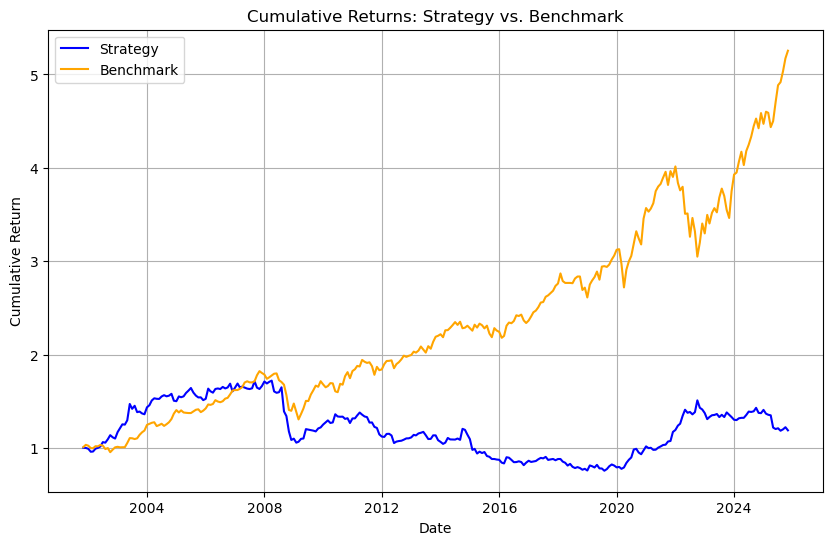

In [94]:
plt.figure(figsize=(10, 6))
plt.plot((1 + results["ret_net"]).cumprod(), label="Strategy", color="blue")
plt.plot((1 + results["ret_bm"]).cumprod(), label="Benchmark", color="orange")
plt.title("Cumulative Returns: Strategy vs. Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
#make the y-axis logarithmic
#plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()